# Cryptocurrency Predictions

### Step 1: Import libraries

In [32]:
import Coinpaprika
import pandas as pd                        
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Step 2: Import Data with CoinPaprika API (https://api.coinpaprika.com/)

In [33]:
api_client = Coinpaprika.Client()

# get market overview
market_overview = api_client.global_market_overview()

# show 10 first coins
all_coins = api_client.coins()
for i  in range(0, 10):
    print(all_coins[i]['id'])

btc-bitcoin
eth-ethereum
usdt-tether
bnb-binance-coin
ada-cardano
doge-dogecoin
xrp-xrp
hex-hex
usdc-usd-coin
dot-polkadot


### Step 3: Get historical data 

In [34]:
# select one coin
coin = 'btc-bitcoin'
color = 'green'

# get historical data
hist = api_client.coins.historical_OHLC(
    coin_id=coin,
    start=datetime.now() - timedelta(weeks=52) - timedelta(days=0),
    end=datetime.now() - timedelta(days=0)
)

# describe data
pd.options.display.float_format = '{:.2f}'.format
df = pd.DataFrame(hist)
df.describe()

,open,high,low,close,volume,market_cap
count,365.00,365.00,365.00,365.00,365.00,365.00
mean,28355.99,29200.59,27455.01,28434.39,36203984166.34,528099486311.41
std,18397.00,18982.10,17719.48,18380.21,22032740726.22,344421373443.12
min,9051.68,9157.41,8956.38,9049.21,10889324562.00,166700714207.00
25%,11330.41,11505.14,11183.11,11336.34,17214139677.00,209370868801.00
50%,19258.18,19522.15,18948.88,19329.35,29190723706.00,357647818067.00
75%,46772.91,48234.07,45132.93,46424.22,52552469404.00,871829542760.00
max,63675.35,65028.97,62214.97,63608.18,136370233019.00,1189580462018.00


In [35]:
# pack closing data into "alldata" array
alldata = []
for i in range(0,len(hist)):
    
    # calculate variance
    variance = hist[i]['high'] - hist[i]['low']
    
    # calculate pdct (predicted difference closing tomorrow)
    if(i == 0):
        pdct = 0
    else:
        pdct = hist[i]['close'] - hist[i-1]['close']
        
    pdctPositive = pdct > 0
    
    alldata.append({"pdctPositive": pdctPositive, 
                    "pdct": pdct, 
                    "close": hist[i]['close'], 
                    "variance": variance, 
                    "time_open": hist[i]['time_open'], 
                    "volume": hist[i]['volume']
                   })

### Step 4: Clean and analyze data

In [36]:
# Clean Serie:
ser = pd.Series(alldata)

# Print the whole dataset including missing values:
print(ser.isnull())

# Print a separation row:
print()

# Show only missing values:
print(ser[ser.isnull()])

0      False
1      False
2      False
3      False
4      False
       ...  
360    False
361    False
362    False
363    False
364    False
Length: 365, dtype: bool

Series([], dtype: object)


In [37]:
# >> there are no null values

In [38]:
# Convert alldata into DataFrame
alldata = pd.DataFrame(alldata)

In [39]:
# find duplicates -> only check the dates
alldata.duplicated(keep = False) # keep = False -> mark every duplicate as True

# >> no duplicates

0      False
1      False
2      False
3      False
4      False
       ...  
360    False
361    False
362    False
363    False
364    False
Length: 365, dtype: bool

In [40]:
print(alldata)

     pdctPositive     pdct    close  variance  time_open       volume
0           False     0.00  9491.11    107.96 2020-06-13  15060483064
1           False  -128.29  9362.82    188.34 2020-06-14  14895201500
2            True    70.22  9433.04    541.44 2020-06-15  23538267469
3            True    96.04  9529.07    175.32 2020-06-16  18155344556
4           False   -56.11  9472.96    245.10 2020-06-17  14739552952
..            ...      ...      ...       ...        ...          ...
360         False  -125.57 33491.44   2677.99 2021-06-08  49889889083
361          True  3945.97 37437.40   4937.27 2021-06-09  56484341435
362         False  -551.67 36885.74   2351.68 2021-06-10  42111440425
363          True   422.90 37308.64   1459.22 2021-06-11  35074798351
364         False -1261.65 36046.99   2487.21 2021-06-12  40309020826

[365 rows x 6 columns]


/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


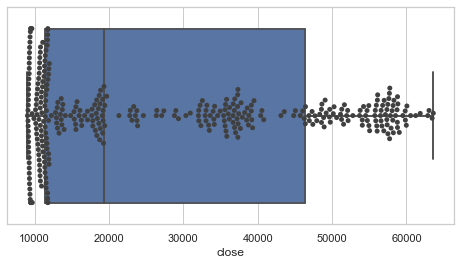

In [41]:
# detect outliers  (https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/)

sns.set_theme(style="whitegrid")
sns.boxplot(alldata['close'])
sns.set(rc={'figure.figsize':(8,4)})

# show points
ax = sns.boxplot(x="close", data=alldata)
ax = sns.swarmplot(x="close", data=alldata, color=".25")

#no outliers

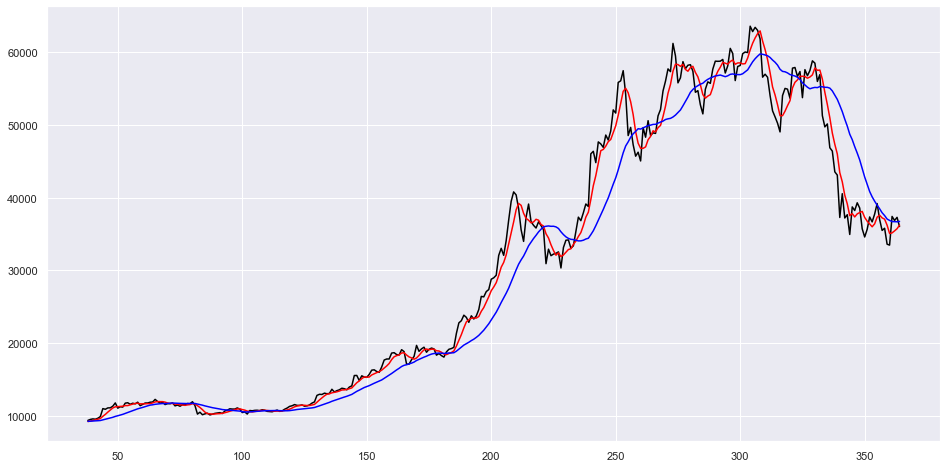

In [66]:
window_short = 5
window_long = 20

#add moving average
alldata[['ma_short']] = alldata[['close']].rolling(window=window_short).mean()
alldata[['ma_long']] = alldata[['close']].rolling(window=window_long).mean()

#remove na (frist couple of datapoints because of movingaverage)
alldata = alldata.dropna()

#show original data with 2 moving averages
plt.figure(figsize=(16,8))
plt.plot(alldata['close'], 'black')
plt.plot(alldata['ma_short'], 'red')
plt.plot(alldata['ma_long'], 'blue')
plt.show()

## Model 1: Classification Tree
#### We want to know if the currency is ascending or descending the next day

In [45]:
def reg_metrics(y_test, y_pred, X_train):

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)
    
    return adj_r_sq

In [46]:
# select test data
numberOfTestData = int(0.2 * len(alldata))

# select feature col
feature_cols = ['close', 'variance', 'volume', 'ma_short', 'ma_long']

X = alldata[feature_cols]       # Features
y = alldata['pdctPositive']     # Target variable: predicted difference closing tomorrow (price goes up or down)

X_train = X[:-numberOfTestData]
X_test  = X[-numberOfTestData:]
y_train = y[:-numberOfTestData]
y_test  = y[-numberOfTestData:]

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

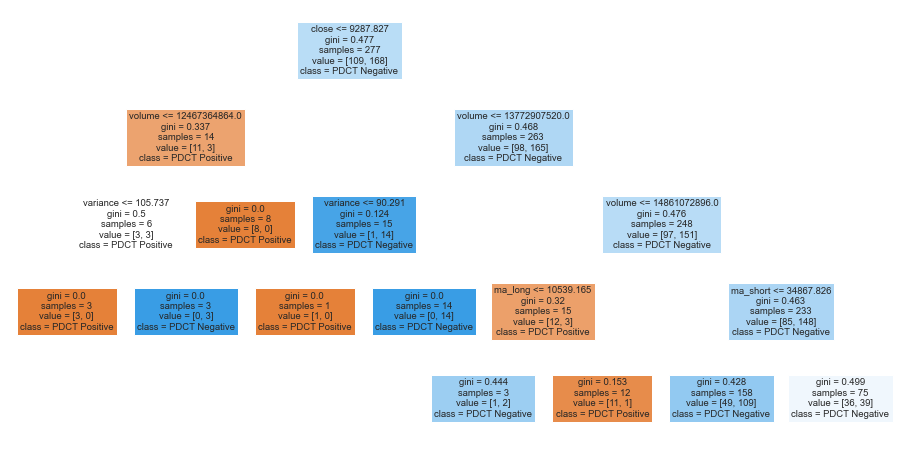

In [53]:
# show tree
fig = plt.figure(figsize=(16,8))
_ = tree.plot_tree(clf, 
                   feature_names=feature_cols,
                   class_names=['PDCT Positive', 'PDCT Negative'],
                   filled=True)

In [48]:
# Model Accuracy, how often is the classifier correct?
#accuracy = reg_metrics(y_test, y_pred, X_train)
accuracy = metrics.accuracy_score(y_test, y_pred)

gini_impurity = clf.cost_complexity_pruning_path(X_train, y_train).impurities

print("gini_impurity is " + str(gini_impurity))
print("model accuracy is " + str(accuracy))

gini_impurity is [0.3906652  0.39656171 0.40330058 0.42031967 0.43091619 0.46093886
 0.47731627]
model accuracy is 0.42028985507246375


              precision    recall  f1-score   support

       False       0.74      0.70      0.72        40
        True       0.61      0.66      0.63        29

    accuracy                           0.68        69
   macro avg       0.67      0.68      0.68        69
weighted avg       0.68      0.68      0.68        69

accuracy: 0.6811594202898551


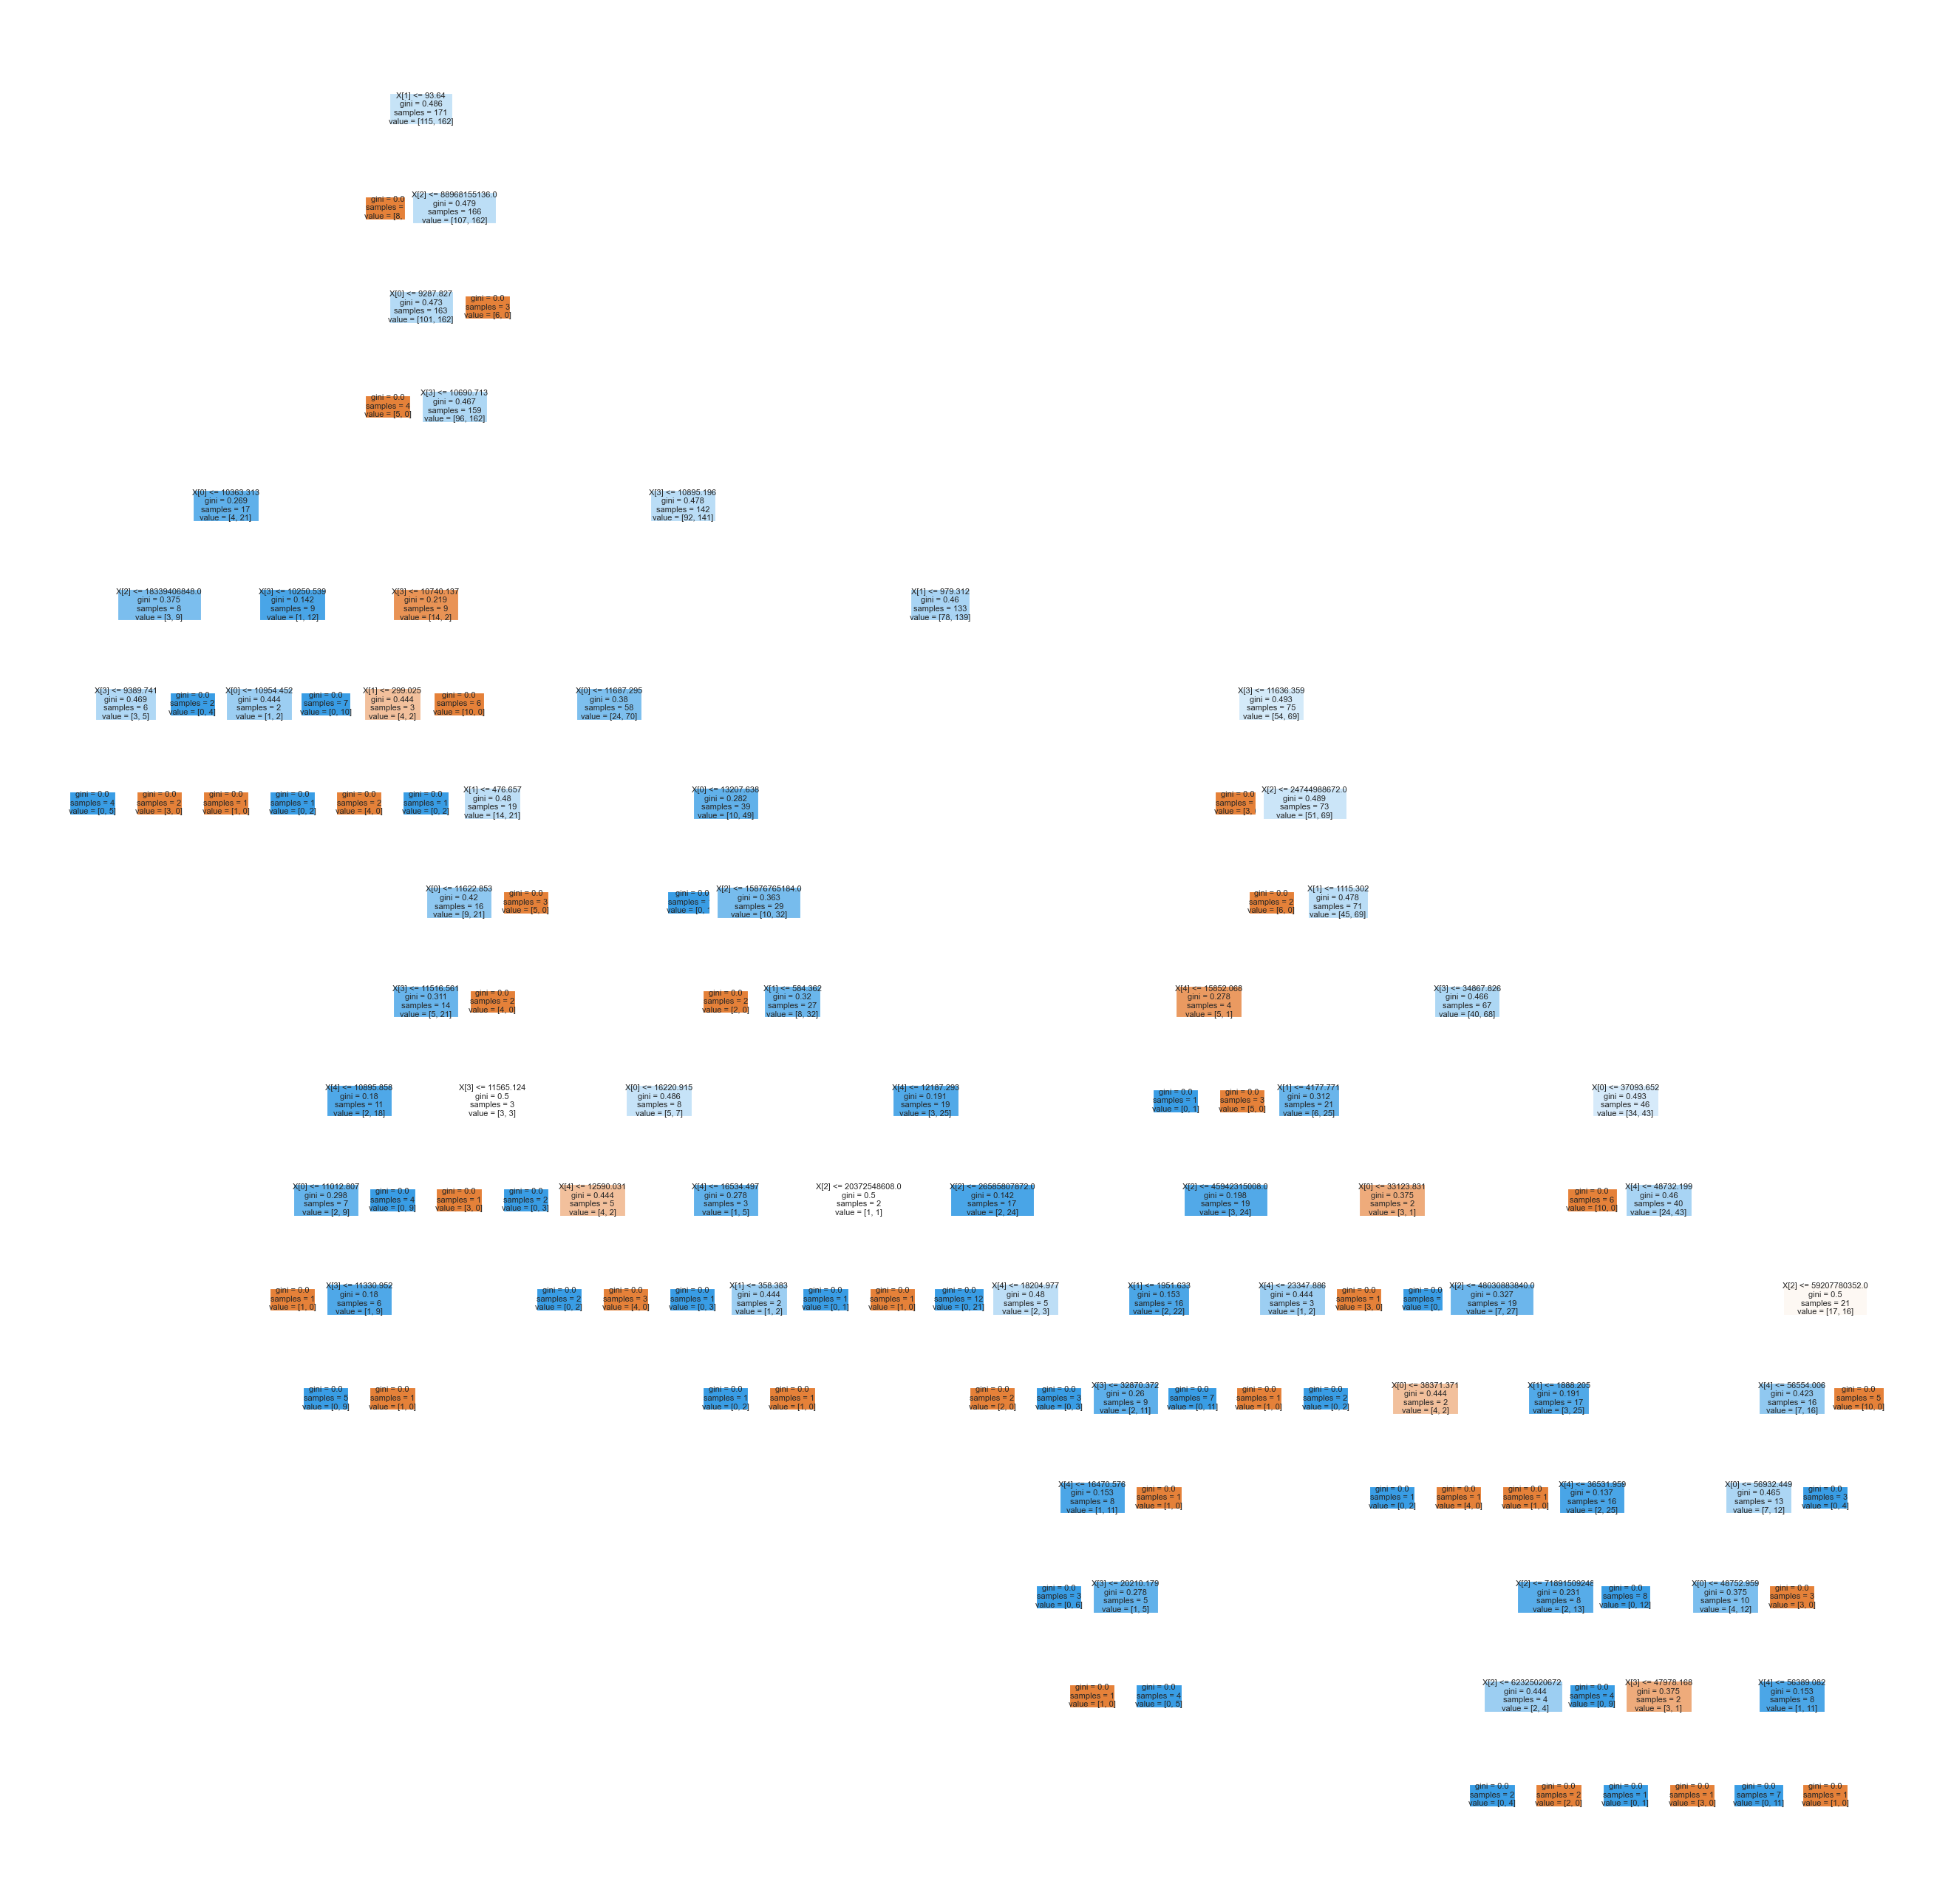

In [54]:
#random forest
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
randomForest.fit(X_train, y_train)
y_pred = randomForest.predict(X_test)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(randomForest.estimators_[0],filled = True);

print(classification_report(y_test,y_pred))
print("accuracy: " + str(accuracy_score(y_test, y_pred)))

## Model 2: Linear Regression
#### We want to predict the currency 

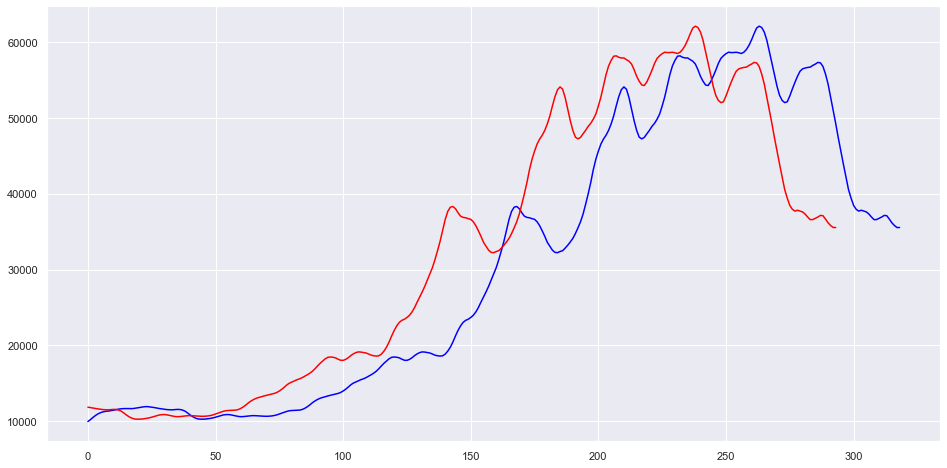

In [142]:
future_days = 25 # prediction over 25 days
window = 5 # moving average over 5 days

# prepare arrays
alldataFrame = pd.DataFrame(alldata[['close']])
alldataFrame[['close']] = alldata[['close']].rolling(window=window).mean()
alldataFrame = alldataFrame.dropna()

alldataFrame['prediction'] = alldataFrame[['close']].shift(-future_days)


X = np.array(alldataFrame.drop(['prediction'], 1))[:-future_days]
y = np.array(alldataFrame['prediction'])[:-future_days]

# get last x rows
x_future = alldataFrame.drop(['prediction'], 1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)

#alldataFrame = alldataFrame.dropna()
alldataFrame = alldataFrame.reset_index(drop=True)

plt.figure(figsize=(16,8))
plt.plot(alldataFrame['close'], 'blue')
plt.plot(alldataFrame['prediction'], 'red')

In [143]:
# split data into 75% training and 25% testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

In [144]:
lr = LinearRegression()

model = lr.fit(x_train, y_train)
prediction = model.predict(x_test)
lr_confidence = lr.score(x_test, y_test)

print("lr_confidence: " + str(lr_confidence))

lr_confidence: 0.7841019531161428


#### predict the future

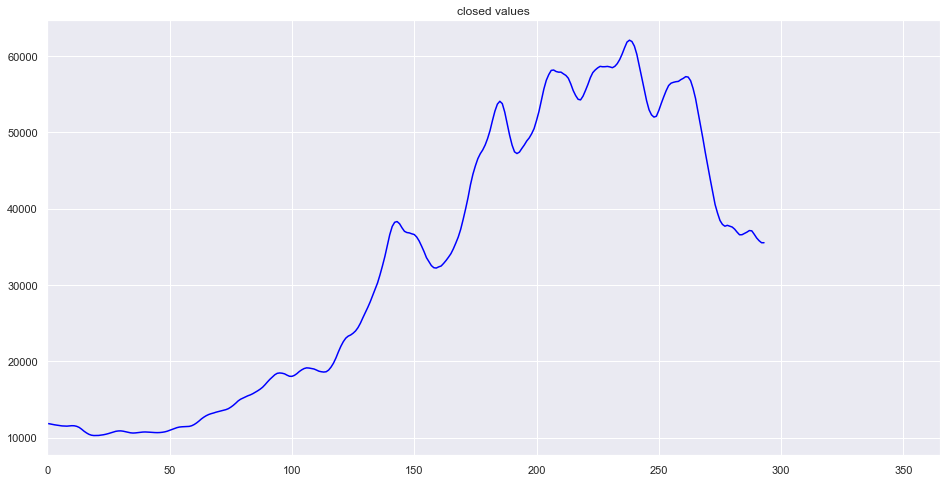

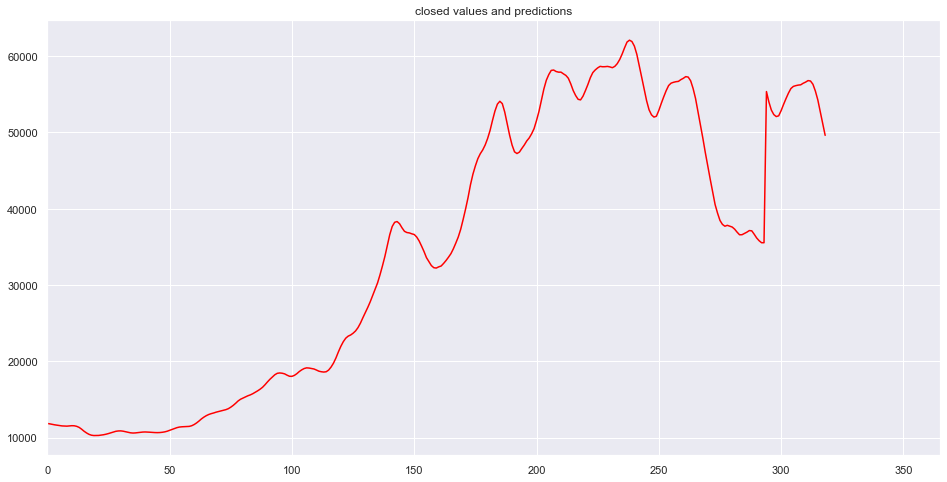

In [145]:
# make prediction
prediction = model.predict(x_future)

# fill dataframe with the closing values
newPrediction = []
for i in range(0, len(alldataFrame['prediction']) - future_days):
    newPrediction.append(alldataFrame['prediction'][i])
    
# append the predictions to dataframe
for i in range(0, len(prediction)):
    newPrediction.append(prediction[i])
    
# synchronize the two data sets (close and prediction)
alldataFrame['prediction'] = newPrediction
alldataFrame['close'] = alldataFrame['close'].shift(-future_days)

# show
plt.figure(figsize=(16,8))
plt.xlim([0, 365])
plt.title("closed values")
plt.plot(alldataFrame['close'], 'blue')
plt.figure(figsize=(16,8))
plt.title("closed values and predictions")
plt.plot(alldataFrame['prediction'], 'red')
plt.xlim([0, 365])
plt.show()

## Model 3: Neural Network
#### We want to predict the currency

In [13]:
# data: take only close-price
alldata = []
for i in range(1,len(hist)):
    alldata.append({
        "close": hist[i]['close']
    })
alldataFrame = pd.DataFrame(alldata)

# use moving average with 5 days
alldataFrame[['close']] = alldataFrame[['close']].rolling(window=5).mean()
alldataFrame = alldataFrame.dropna()

In [14]:
# use scaler to reshape the data
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(alldataFrame.values)

In [15]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

# preprocess data
SEQ_LEN = 100
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.85)

# show train / test data split
print(X_train.shape)
print(X_test.shape)

(221, 99, 1)
(39, 99, 1)


In [26]:
# settings
DROPOUT = 0.15
WINDOW_SIZE = SEQ_LEN - 1
BATCH_SIZE = 32

# create model
model = keras.Sequential()
model.add(Bidirectional(LSTM(WINDOW_SIZE * 3, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# fit model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/10
7/7 [==============================] - 12s 766ms/step - loss: 0.0149 - val_loss: 0.0178
Epoch 2/10
7/7 [==============================] - 4s 513ms/step - loss: 0.0334 - val_loss: 0.0251
Epoch 3/10
7/7 [==============================] - 4s 527ms/step - loss: 0.0471 - val_loss: 0.0089
Epoch 4/10
7/7 [==============================] - 4s 498ms/step - loss: 0.0621 - val_loss: 0.0038
Epoch 5/10
7/7 [==============================] - 3s 472ms/step - loss: 0.0276 - val_loss: 0.0208
Epoch 6/10
7/7 [==============================] - 4s 503ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 7/10
7/7 [==============================] - 3s 487ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 8/10
7/7 [==============================] - 3s 496ms/step - loss: 0.0016 - val_loss: 0.0181
Epoch 9/10
7/7 [==============================] - 4s 508ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 10/10
7/7 [==============================] - 4s 502ms/step - loss: 0.0015 - val_loss: 0.0050


In [27]:
# show model error
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 52ms/step - loss: 0.0439


0.04391219839453697

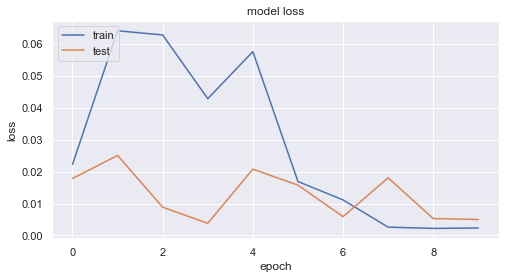

In [28]:
# plot model evolution
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

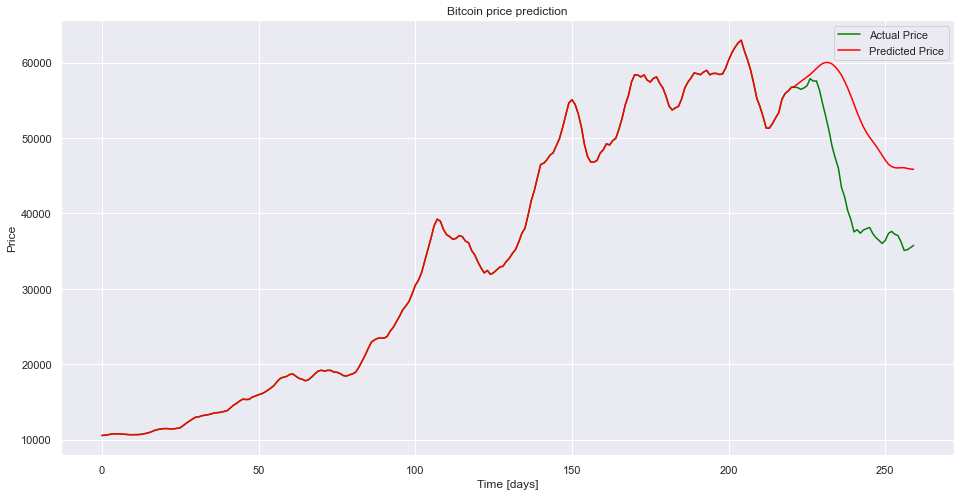

In [29]:
y_prediction = model.predict(X_test)

y_train_inverse = scaler.inverse_transform(y_train)
y_test_inverse = scaler.inverse_transform(y_test)


y_testclose = []
for i in range(0, len(y_test_inverse)):
    y_testclose.append(y_test_inverse[i][0])
    
scale = y_test_inverse[0][0] / y_test[0][0]
y_predictclose = []
for i in range(0, len(y_prediction)):
    y_predictclose.append(y_prediction[i] * scale)
 

#alldata
y_actual_complete = []
y_predict_complete = []
for i in range(0, (len(y_train_inverse) + len(y_test_inverse))):
    if i < len(y_train_inverse):
        y_actual_complete.append(y_train_inverse[i])
        y_predict_complete.append(y_train_inverse[i])
    else:
        y_actual_complete.append(y_test_inverse[(i - len(y_train_inverse))])
        y_predict_complete.append(y_predictclose[(i - len(y_train_inverse))])


plt.figure(figsize=(16,8))
plt.plot(y_actual_complete, label="Actual Price", color='green')
plt.plot(y_predict_complete, label="Predicted Price", color='red')
    
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [31]:
print(mean_squared_error(y_test, y_prediction))
print(mean_absolute_error(y_test, y_prediction))

0.04391220591739819
0.1833586814157964
